In [90]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import nibabel as nib
import pandas
from matplotlib import cm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import pyvista as pv

In [91]:
FONT_TITLE_PLOT = {'family': 'sans-serif',
                   'color':  'black', 
                   'fontweight': 'bold',
                   'fontsize': 14}

FONT_LABEL_PLOT = {'family': 'sans-serif',
                   'color':  'black', 
                   'fontweight': 'normal',
                   'fontsize': 12}

FONT_LEGEND_PLOT = {'family': 'sans-serif',
                    'color':  'black', 
                    'fontweight': 'normal',
                    'fontsize': 12}

# Data import and partition

## Preprocessed data import
The data have already been preprocessed using the matlab class PSM (using the generateExportData function). Dataset with voxel size from 500 um to 2000 um have been generated and are located in in the folder "../../03_Data/"

In [92]:
# TODO add the electrodes centers in the panda dataframe
df = pandas.read_csv('../../03_Data/01_Tables/multicentricTableAllImprovedOnlyRev04.csv')

# Filter table if needed (right)
df = df.loc[np.logical_not(np.mod(2*df.leadID, 2).astype(bool))]

# Filter table if needed (left)
#df = df.loc[(np.mod(2*df.leadID, 2).astype(bool))]

# Load vectorized VTA matrix
dataset = scipy.io.loadmat('../../03_Data/05_Datasets/right_hemisphere/dataset_right_500um.mat')

X = np.clip(np.array(dataset['X']), 0, 1)
y = np.squeeze(np.array(dataset['y']))

CONTAINER_AFFINE = np.squeeze(np.array(dataset['container_affine']))
CONTAINER_SHAPE = np.squeeze(np.array(dataset['container_shape']))


X = np.hstack([X, np.expand_dims(df.amplitude.to_numpy(), axis=0).T])

X = np.delete(X, 0, 1)

# Create partitions of training and testing sets
kf = KFold(n_splits=10, random_state=None, shuffle=True)

# scaler = StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

#print("min_test = ", np.argmin(X_test[:, :-1]))
#print("max_test = ", np.argmax(X_test[:, :-1]))
# ISSUE: the standard scaler does not work

#newrow1 = np.ones((1, X.shape[1]))
#newrow0 = np.zeros((1, X.shape[1]))
#newrow0[0, 0] = 1

#X_train = np.vstack((X_train, newrow0))
#y_train = np.hstack((y_train, 0))

#print("Number of features:    n = ", np.sum(np.max(X_train, axis=0), axis=0))


In [93]:
# Load STN polygon
pv.set_jupyter_backend('panel')
reader = pv.get_reader('templates/anatomyDISTALminimal.ply')
ANATOMY_MESH = reader.read()

# Plot functions

Before going into the generation of the maps, this section creates function useful to observe and compare the probabilistic maps.

### Reconstruction of a VTA
As the data (the VTA voxels values) are provided under a vectorized form, it is necessary to be able to reconstruct the map. The first feature of the matrix is the intercept term and is cannot be displayed with the rest of the map voxels.

In [94]:
def logit(x):
    eps = 1e-3
    return np.log((x+eps)/(1-x+eps))

def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

def normalize(arr):
    arr_min = np.min(arr)
    return (arr-arr_min)/(np.max(arr)-arr_min)

def show_histogram(image):

    # Create the histogram
    histogram, bin_edges = np.histogram(image, bins=256, range=(0, 1))

    # Configure and draw the histogram figure
    plt.figure()
    plt.title("Grayscale Histogram")
    plt.xlabel("grayscale value")
    plt.ylabel("pixels")
    plt.xlim([0.0, 1.0])
    plt.plot(bin_edges[0:-1], histogram)
    plt.show()

def reconstruct(vector):
    # Function to reconstruct a tensor (3D image) from the vectorized image based on the container shape

    amplitude_coeff = vector[-1]
    vector = vector[0:-1]

    tensor = np.reshape(vector, CONTAINER_SHAPE, order='F')

    return tensor, amplitude_coeff

def homogeneous_transform(coord, transform, isvector=0):
    # Apply transform to the points array p0
    # [p1 1]^T = M x [p0 1]^T

    if isvector:
        coord = np.concatenate((coord, np.zeros((1, coord.shape[1]))), axis=0)
    else:
        coord = np.concatenate((coord, np.ones((1, coord.shape[1]))), axis=0)

    transformed_coord = transform @ coord

    return transformed_coord[0:3, :].T

def mat2pcd(tensor, threshold=1e-2, transform=CONTAINER_AFFINE):

    # Get all indices of the tensor image and create a Nx3 coordinates array
    xx, yy, zz = np.indices(np.array(tensor.shape))
    coord = [xx.flatten(), yy.flatten(), zz.flatten()]

    # Get the Nx1 image values array
    values = tensor[coord]

    points = homogeneous_transform(np.vstack(coord), transform)
    todelete = np.argwhere(np.abs(values) < threshold)

    values = np.delete(values, todelete, axis=0)
    points = np.delete(points, todelete, axis=0)

    pcd = pv.PolyData(points)
    data = values
    #print(points.shape)
    #print(data.shape)

    # Add that data to the mesh with the name "uniform dist"
    pcd["coef"] = values

    return pcd

## Map plot
The plots of the map shall allow the vizualization of the map inside the MNI space. It is  important that the plot are easy to understand in order to give better insights about the stimulation sweet and sour spots. The function plot maps allows to plot the map in 3D (scatter) or see it in 2D as a image. In both cases the surrounding anatomy is displayed.

In [104]:
def plot_map(coef,
             intercept = 0,
             dim='2D', 
             plane='axial',
             slice_index=int(CONTAINER_SHAPE[0]/2),
             view_angle=320,
             markersize=5,
             dispthreshold=1e-2,
             anatomy='full'):

    print(markersize)
    tensor, amplitude_coeff = reconstruct(coef)

    if dim == '2D':
        plot_slice(tensor, intercept, slice_index, plane)
        
    elif dim == '3D':
        return plot_volume(tensor, intercept, view_angle, markersize, dispthreshold, anatomy)

def plot_slice(tensor, intercept, slice_index, plane):
    # Function to plot a slice of the map on a 2D figure
    
    fig = plt.figure(figsize=(25/2.54, 25/2.54))
    ax = plt.axes()
    plt.ion()
    plt.set_cmap('viridis')

    if plane == 'axial':
        img = tensor[:, :, slice_index] + intercept
        max_img = np.max(np.abs(img))
        plt.pcolor(img, vmin=-max_img, vmax=max_img)
        plt.colorbar()
        ax.set_xlabel('Medial-lateral (mm)', fontdict=FONT_LABEL_PLOT)
        ax.set_ylabel('Posterior-anterior (mm)', fontdict=FONT_LABEL_PLOT)
        
    elif plane == 'sagittal':
        img = tensor[:, slice_index, :] + intercept
        max_img = np.max(np.abs(img))
        plt.pcolor(img, vmin=-max_img, vmax=max_img)
        plt.colorbar()
        ax.set_xlabel('Medial-lateral (mm)', fontdict=FONT_LABEL_PLOT)
        ax.set_ylabel('Inferior-superior (mm)', fontdict=FONT_LABEL_PLOT)
        
    elif plane == 'coronal':
        img = tensor[slice_index, :, :] + intercept
        max_img = np.max(np.abs(img))
        plt.pcolor(img, vmin=-max_img, vmax=max_img)
        plt.colorbar()
        ax.set_xlabel('Posterior-anterior (mm)', fontdict=FONT_LABEL_PLOT)
        ax.set_ylabel('Inferior-superior (mm)', fontdict=FONT_LABEL_PLOT)
        
    plt.show()

def plot_volume(cube, intercept, view_angle, markersize, threshold, anatomy):

    cmap = plt.cm.get_cmap("viridis", 20)
    map_pcd = mat2pcd(cube+intercept, threshold)

    plotter = pv.Plotter(window_size=(500, 500))

    if anatomy == 'STN':
        plotter.add_mesh(STN_MESH,
                         label='Anatomy',
                         color='white',
                         opacity=0.6)
    elif anatomy == 'full':
        plotter.add_mesh(ANATOMY_MESH,
                         label='Anatomy',
                         color='white',
                         opacity=0.6)

    plotter.add_points(map_pcd,
                       cmap=cmap,
                       point_size=markersize)
    plotter.add_legend()
    plotter.set_background('white')
    plotter.renderer.add_axes(interactive=None, line_width=2, color=None, x_color='blue', y_color='green', z_color='red', xlabel='X', ylabel='Y', zlabel='Z', labels_off=False)
    plotter.show()

    return plotter
    #plotter.screenshot(filename='./airplane.png')


## Results plot
The results plot will be used in order to assess the quality of a model. It includes:
   - Prediction vs ground truth on testing set,
   - Prediction vs ground truth on training set,
   - Coefficient of determination of between variable prediction and ground truth,
   - Residual plot and QQ plot of those.

In [96]:
# Function used to visualize the accuracy of a model on testing and training data
def plot_results(model, X_test, y_test, X_train, y_train, transformed=False):

    pred_test = model.predict(X_test)
    pred_train = model.predict(X_train)

    if transformed:
        pred_test = invlogit(pred_test)
        pred_train = invlogit(pred_train)
        coef_deter_test = model.score(X_test, logit(y_test))
        coef_deter_train = model.score(X_train, logit(y_train))

    else:
        coef_deter_test = model.score(X_test, y_test)
        coef_deter_train = model.score(X_train, y_train)

    # Create figure and axes
    fig, axs = plt.subplots(1, 2)

    # Set figure size and name
    fig.tight_layout()
    fig.suptitle('Clinical improvement prediction', y=0.8, fontsize=14, fontweight='bold')
    fig.set_size_inches(25/2.54, 25/2.54)

    # Set axe properties
    axs[0].set_title('Testing data', fontdict=FONT_TITLE_PLOT)
    axs[0].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
    axs[0].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
    axs[0].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
    axs[0].scatter(pred_test, y_test, s=8)
    axs[0].set_aspect('equal', 'box')

    axs[1].set_title('Training data', fontdict=FONT_TITLE_PLOT)
    axs[1].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
    axs[1].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
    axs[1].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
    axs[1].scatter(pred_train, y_train, s=8)
    axs[1].set_aspect('equal', 'box')

    if False:# transformed:
        axs[0].set_xlim([-0.05, 1.05])
        axs[0].set_ylim([-0.05, 1.05])

        axs[1].set_xlim([-0.05, 1.05])
        axs[1].set_ylim([-0.05, 1.05])

    # Show figure
    plt.show()

    # Print the value of the R2
    print("Coefficient of determination (R²):")
    print("     - testing  :    ", coef_deter_test)
    print("     - training :    ", coef_deter_train)

## Export map

In [97]:
import pickle

def save_map(model, filename='../../03_Data/06_Maps/map_v@'):
    image, intercept_coef, amplitude_coef = reconstruct(model.coef_.T)
    ni_img = nib.Nifti1Image(image, CONTAINER_AFFINE)
    print(filename + '.nii.gz')
    nib.save(ni_img, filename + '.nii.gz')

    dict_coef = {'intercept': intercept_coef, 'amplitude': amplitude_coef}

    output = open(filename + '.pkl', 'wb')
    pickle.dump(dict_coef, output)
    output.close()



#Ssave_map(model)

# Probabilistic Stimulation for deep brain stimulation

## N-Image

In [98]:
STN_nii = nib.load('./templates/STN.nii.gz')
STN_pcd = mat2pcd(STN_nii.get_fdata(), threshold=1e-2, transform=STN_nii.affine)
# get_fdata???
STN_MESH = STN_pcd.delaunay_3d(progress_bar=True)


Computing 3D Triangulation: 100%|██████████[00:05<00:00]


In [99]:
n_image = []
n_image = np.sum(X, axis=0)
plot_map(n_image, dim='3D', markersize=5, dispthreshold=50)
save_map(n_image)

5


AttributeError: 'numpy.ndarray' object has no attribute 'coef_'

5


5


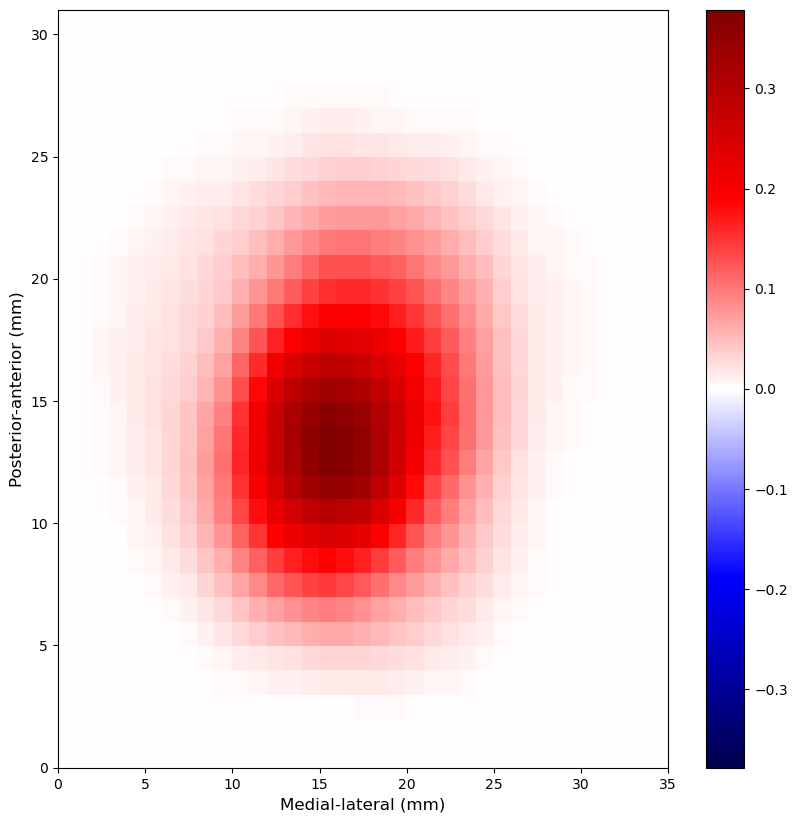

In [100]:
mean_image = np.mean(X * y[np.newaxis, :].T, axis=0)
plot_map(mean_image, dim='3D')
plot_map(mean_image, dim='2D')

## Linear Models
### Linear regression (response variable in unit interval)
Both linear regression (with response variable in unit interval or real numbers) show the typical signs of overfiting. The training accuracy is very high and generalize very poorly. The map also shows that the learned parameters completely ignored the regions stimulated by a lot of VTAs and gives more importance to the surrounding voxels stimulated by less voxels.

5


5


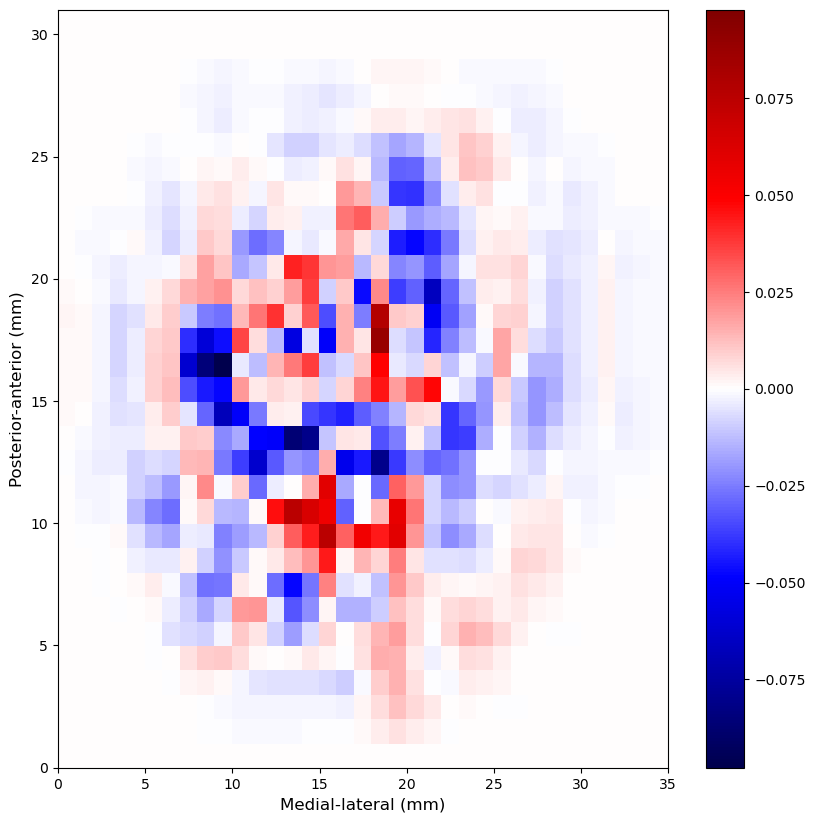

In [101]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = model.fit(X_train, y_train)
    #plot_results(model, X_test, y_test, X_train, y_train, transformed=False)

plot_map(model.coef_, dim='3D', dispthreshold=0.01, anatomy='STN')
plot_map(model.coef_, dim='2D')

### Linear regression (response variable transformed in real positive)

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model = model.fit(X_train, logit(y_train))

plot_results(model, X_test, y_test, X_train, y_train, transformed=True)
plot_map(model.coef_, intercept=model.intercept_, dim='3D')
plot_map(model.coef_, dim='2D')

### Bayesian Linear regression

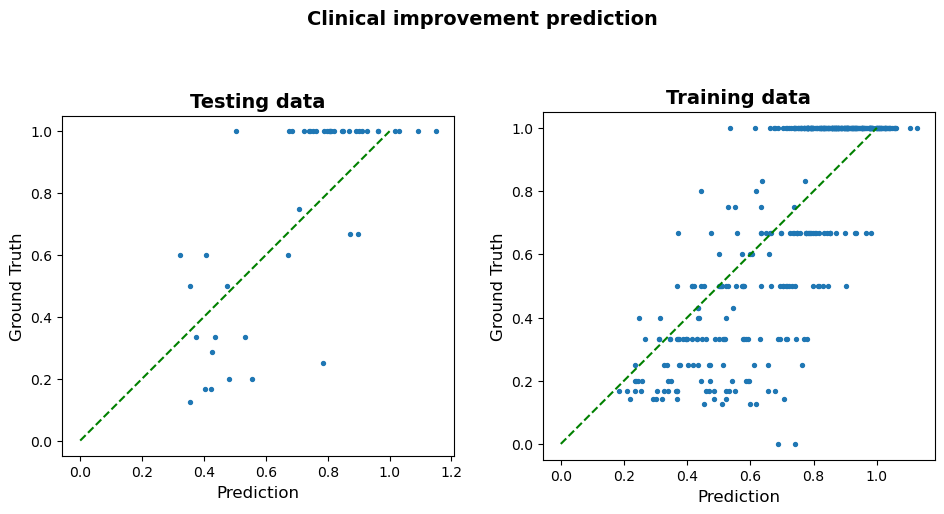

Coefficient of determination (R²):
     - testing  :     0.5314649928548899
     - training :     0.6472886469231474
4


2


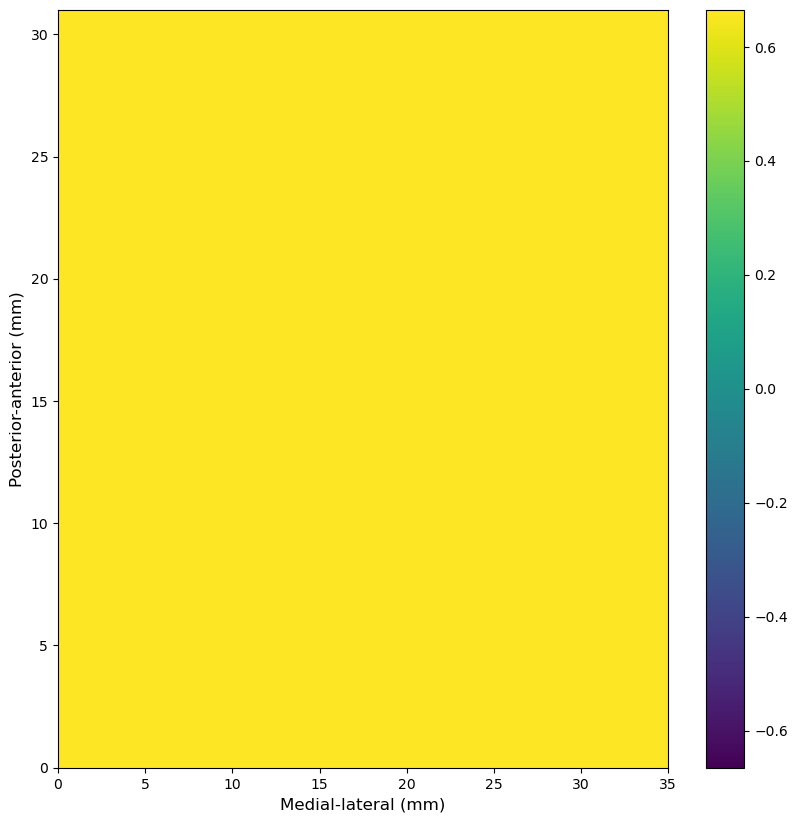

In [114]:
from sklearn.linear_model import BayesianRidge

model = BayesianRidge(alpha_1=8e-1, alpha_2=5e-3, lambda_1=1e-1, lambda_2=1e-3, fit_intercept=True)

BayesianResults = []
models = []

pred_test_overall = []
y_test_overall = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train)

    pred_test_overall.append(model.predict(X_test))
    y_test_overall.append(y_test)

    BayesianResults.append(model.score(X_test, y_test))
    models.append(model)

bestBayesianModel = models[np.argmax(BayesianResults)]
models = []

plot_results(bestBayesianModel, X_test, y_test, X_train, y_train, transformed=False)
plot_map(bestBayesianModel.coef_, intercept=model.intercept_, dim='3D', markersize=4, anatomy='STN', dispthreshold=0.003)
plot_map(bestBayesianModel.coef_, intercept=model.intercept_, dim='2D', slice_index=3, anatomy='STN', markersize=2)

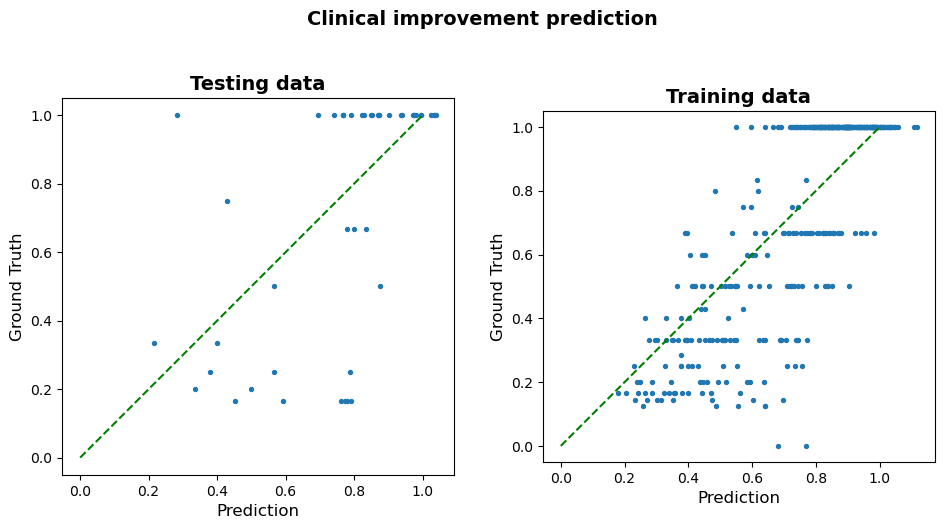

Coefficient of determination (R²):
     - testing  :     0.3443422947284228
     - training :     0.6479696494972219
4


2


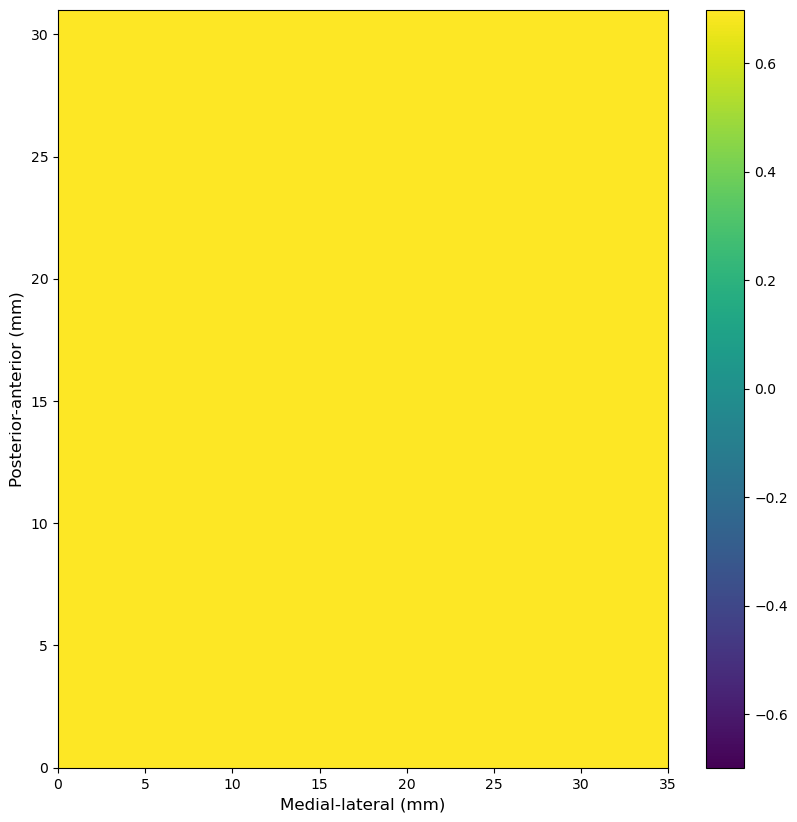

In [113]:
plot_results(bestBayesianModel, X_test, y_test, X_train, y_train, transformed=False)
plot_map(bestBayesianModel.coef_, intercept=model.intercept_, dim='3D', markersize=4, anatomy='STN', dispthreshold=0.65)
plot_map(bestBayesianModel.coef_, intercept=model.intercept_, dim='2D', slice_index=3, anatomy='STN', markersize=2)

In [48]:
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

scaler = MinMaxScaler()
pca = PCA()
model = BayesianRidge(alpha_1=8e-1, alpha_2=5e-3, lambda_1=1e-1, lambda_2=1e-3)
model = SVC(gamma=2, C=1),
#pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("model", model)])
pipe = Pipeline(steps=[("pca", pca), ("model", model)])

param_grid = {
    "pca__n_components": [5, 15, 30, 45, 60, 100, 200, 300],
}
search = GridSearchCV(pipe, param_grid, n_jobs=1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


#plot_results(pipe, X_test, y_test, X_train, y_train, transformed=False)
#plot_map(model.coef_, dim='3D', markersize=4, anatomy='STN', dispthreshold=0.003)
#plot_map(model.coef_, dim='2D', slice_index=3, anatomy='STN', markersize=2)

TypeError: Last step of Pipeline should implement fit or be the string 'passthrough'. '(SVC(C=1, gamma=2),)' (type <class 'tuple'>) doesn't

### Lasso regression

/home/brainstimmaps/.conda/envs/PSM/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  after removing the cwd from sys.path.
/home/brainstimmaps/.conda/envs/PSM/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)


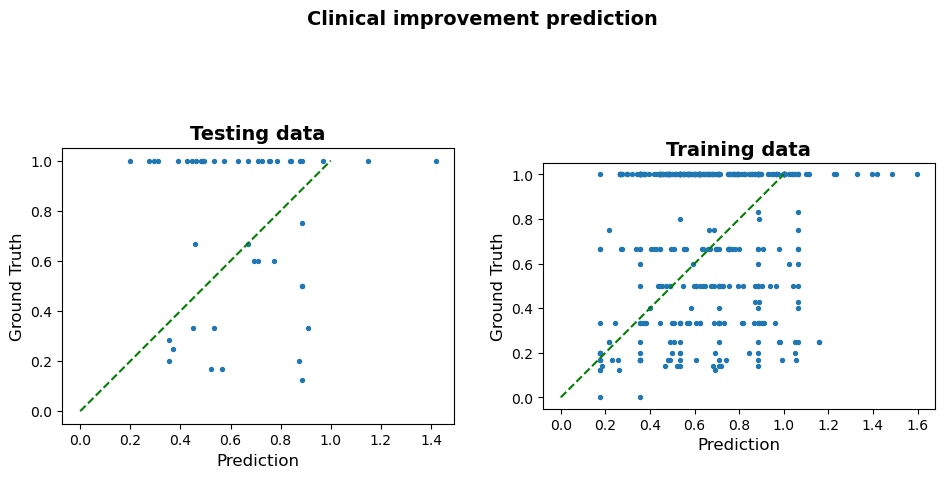

Coefficient of determination (R²):
     - testing  :     -0.7134433790315986
     - training :     -0.4809967884893396
5


5


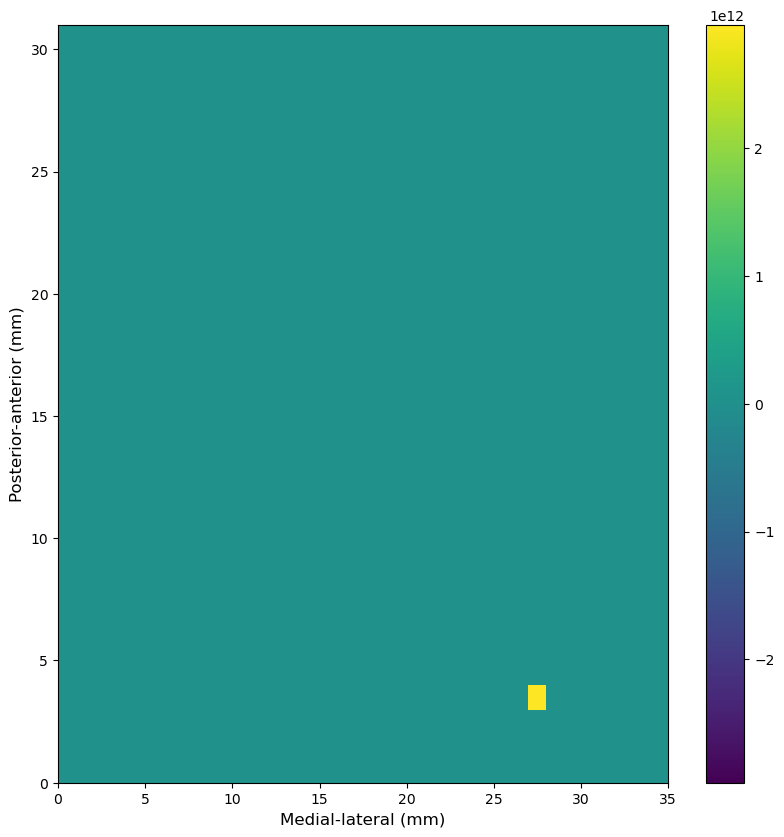

In [120]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0, random_state=0, fit_intercept=False, positive=True)
model = model.fit(X_train, (y_train))
plot_results(model, X_test, y_test, X_train, y_train, transformed=False)
plot_map(model.coef_, dim='3D', anatomy='STN')
plot_map(model.coef_, dim='2D')


### Elastic Nets

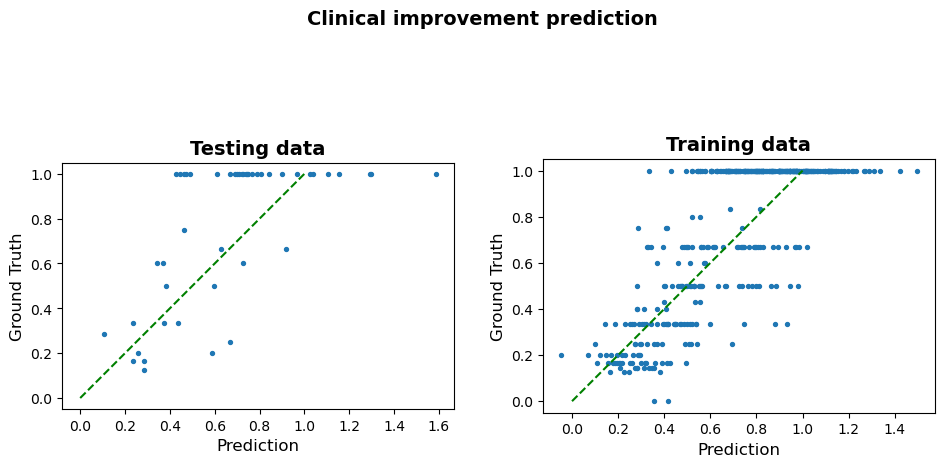

Coefficient of determination (R²):
     - testing  :     0.17447903179462432
     - training :     0.5792418640908034
5


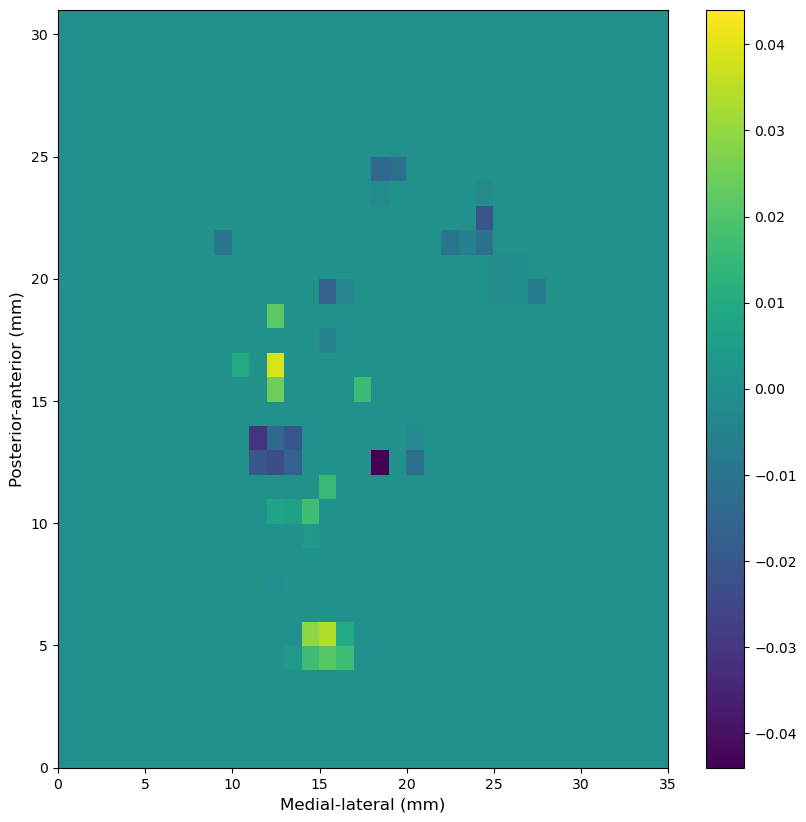

5


In [131]:
from sklearn.linear_model import ElasticNet

model = ElasticNet(random_state=43, alpha=0.02, l1_ratio=0.05, max_iter=10000, fit_intercept=False)


model = model.fit(X_train, y_train)


plot_results(model, X_test, y_test, X_train, y_train, transformed=False)

plot_map(model.coef_, intercept=model.intercept_, dim='2D')
plot_map(model.coef_, intercept=model.intercept_, dim='3D', anatomy='STN')

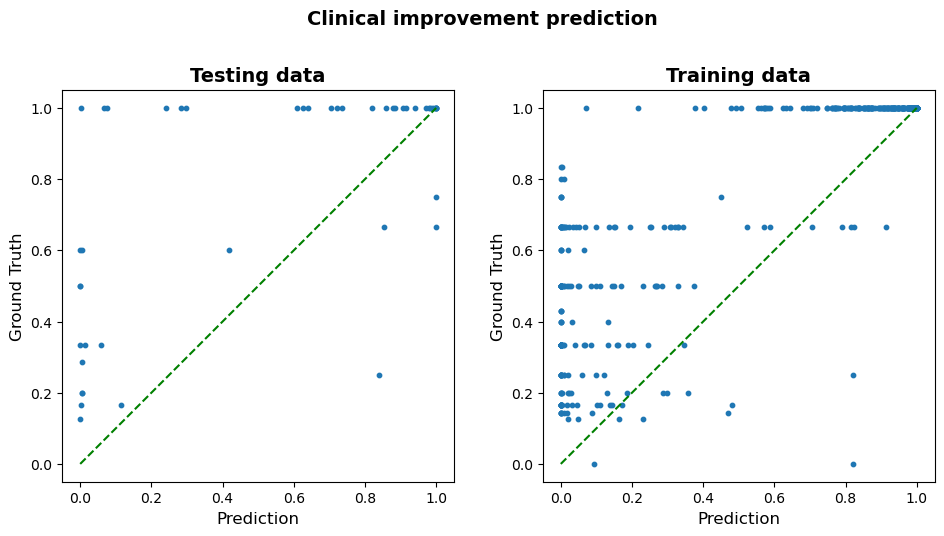

Coefficient of determination (R²) of regresssion:
     - testing  :     0.41039289958960273
     - training :     0.7325917280505673
Accuracy of classification:
     - testing  :     0.782608695652174
     - training :     0.9615384615384616


In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier

scaler = StandardScaler()
pca = PCA(n_components=250)
logistic = LogisticRegression(max_iter=10000, tol=0.1, C=0.1, solver="newton-cg", class_weight='balanced', fit_intercept=True)
#logistic = LinearDiscriminantAnalysis()
pip = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])

pip.fit(X_train, np.round(y_train-0.49))

pred_test = pip.predict_proba(X_test)
pred_train = pip.predict_proba(X_train)

conf_test = pip.decision_function(X_test)
conf_train = pip.decision_function(X_train)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pred_test[:, 1], y_test)
coef_deter_test = r_value**2

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pred_train[:, 1], y_train)
coef_deter_train = r_value**2

# Create figure and axes
fig, axs = plt.subplots(1, 2)

# Set figure size and name
fig.tight_layout()
fig.suptitle('Clinical improvement prediction', y=0.8, fontsize=14, fontweight='bold')
fig.set_size_inches(25/2.54, 25/2.54)

# Set axe properties
axs[0].set_title('Testing data', fontdict=FONT_TITLE_PLOT)
axs[0].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
axs[0].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
axs[0].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
axs[0].scatter(pred_test[:, 1], y_test, s=10)
axs[0].set_aspect('equal', 'box')
axs[0].set_xlim([-0.05, 1.05])
axs[0].set_ylim([-0.05, 1.05])

axs[1].set_title('Training data', fontdict=FONT_TITLE_PLOT)
axs[1].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
axs[1].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
axs[1].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
axs[1].scatter(pred_train[:, 1], y_train, s=10)
axs[1].set_aspect('equal', 'box')
axs[1].set_xlim([-0.05, 1.05])
axs[1].set_ylim([-0.05, 1.05])

# Show figure
plt.show()

# Print the value of the R2
print("Coefficient of determination (R²) of regresssion:")
print("     - testing  :    ", coef_deter_test)
print("     - training :    ", coef_deter_train)

print("Accuracy of classification:")
print("     - testing  :    ", pip.score(X_test, np.round(y_test -0.49)))
print("     - training :    ", pip.score(X_train, np.round(y_train-0.49)))

#plot_map(logistic.coef_.T, dim='3D', dispthreshold=0.08, anatomy='STN')




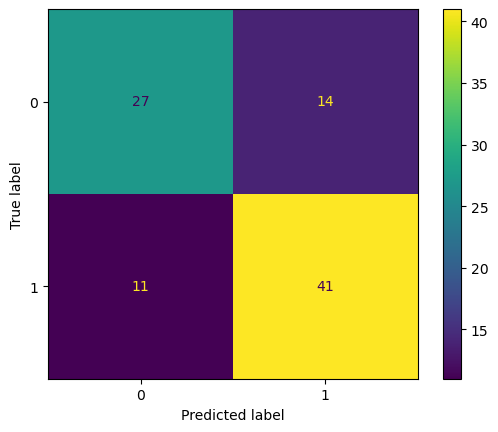

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = pipe.predict(X_test)
cm = confusion_matrix(np.round(y_test-0.49), y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()



## Generalized Linear Models
### Logistic Regression
Cannot be used with a continuous response variable because it relies on the Bernoulli distribution which is not applicable to a continuous variable as the clinical improvement. But by rounding the response variable to a binary outcome in the training set and then evaluating the probability of the response against the continuous test response it is possible to use this model

In [18]:
X_train_logReg = np.tile(X_train, (10, 1))
y_train_logReg = []
for k in range(10):
    index = np.where(y_train < k/10)
    to_append = np.copy(y_train)
    to_append[index] = 0

    y_train_logReg = np.hstack((y_train_logReg, to_append))

index = np.where(y_train_logReg > 0.1)
y_train_logReg[np.where(y_train_logReg > 0.1)] = 1


In [19]:
X_train_logReg = X_train
y_train_logReg = y_train

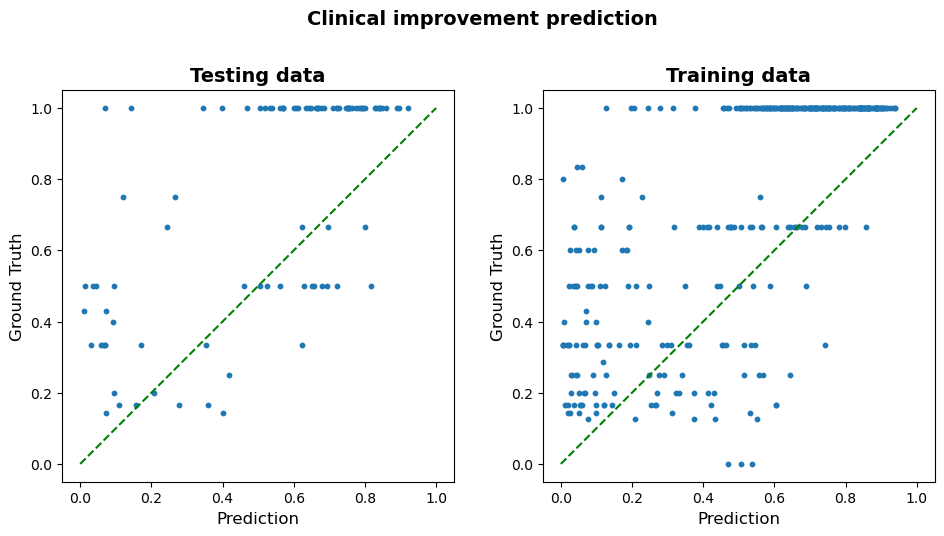

Coefficient of determination (R²):
     - testing  :     0.43726921188199314
     - training :     0.5297190164843687
Accuracy of classification:
     - testing  :     0.6774193548387096
     - training :     0.8567567567567568
5


../../03_Data/06_Maps/map_v@.nii.gz


In [73]:
from sklearn.linear_model import LogisticRegression

# Update data set to


model = LogisticRegression(max_iter=10000, tol=1e-6, C=0.01, penalty='l2', dual=False, solver='newton-cg', class_weight='balanced', intercept_scaling=0.001)
model = model.fit(X_train_logReg, np.round(y_train_logReg-0.4).astype('int'))

pred_test = model.predict_proba(X_test)
pred_train = model.predict_proba(X_train)

conf_test = model.decision_function(X_test)
conf_train = model.decision_function(X_train)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pred_test[:, 1], y_test)
coef_deter_test = r_value**2

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pred_train[:, 1], y_train)
coef_deter_train = r_value**2

# Create figure and axes
fig, axs = plt.subplots(1, 2)

# Set figure size and name
fig.tight_layout()
fig.suptitle('Clinical improvement prediction', y=0.8, fontsize=14, fontweight='bold')
fig.set_size_inches(25/2.54, 25/2.54)

# Set axe properties
axs[0].set_title('Testing data', fontdict=FONT_TITLE_PLOT)
axs[0].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
axs[0].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
axs[0].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
axs[0].scatter(pred_test[:, 1], y_test, s=10)
axs[0].set_aspect('equal', 'box')
axs[0].set_xlim([-0.05, 1.05])
axs[0].set_ylim([-0.05, 1.05])

axs[1].set_title('Training data', fontdict=FONT_TITLE_PLOT)
axs[1].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
axs[1].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
axs[1].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
axs[1].scatter(pred_train[:, 1], y_train, s=10)
axs[1].set_aspect('equal', 'box')
axs[1].set_xlim([-0.05, 1.05])
axs[1].set_ylim([-0.05, 1.05])

# Show figure
plt.show()

# Print the value of the R2
print("Coefficient of determination (R²):")
print("     - testing  :    ", coef_deter_test)
print("     - training :    ", coef_deter_train)

print("Accuracy of classification:")
print("     - testing  :    ", pipe.score(X_test, np.round(y_test-0.4)))
print("     - training :    ", pipe.score(X_train, np.round(y_train-0.4)))

plot_map(model.coef_.T, dim='3D', dispthreshold=0.01, anatomy='STN')

save_map(model)


### Logistic Regression (stats)

In [109]:
import statsmodels.api as sm

logit_mod = sm.Logit(np.round(y_train_logReg).astype('int'), X_train_logReg)

logit_res = logit_mod.fit_regularized()



NameError: name 'y_train_logReg' is not defined

### Beta Regression

In [ ]:
from scipy.optimize import minimize
from sklearn.linear_model import Lasso
from scipy.special import loggamma
from scipy.special import expit, logit
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

def logLikelihood(params, y, X):
    b = np.array(params[0:-1])      # the beta parameters of the regression model
    phi = params[-1]                # the phi parameter
    mu = expit(np.dot(X,b))

    eps = 1e-6                      # used for safety of the gamma and log functions avoiding inf
    res = - np.sum(loggamma(phi+eps) # the log likelihood
                   - loggamma(mu*phi+eps)
                   - loggamma((1-mu)*phi+eps)
                   + (mu*phi-1)*np.log(y+eps)
                   + ((1-mu)*phi-1)*np.log(1-y+eps))

    return res

def penalty(params, C=2, C1_ratio=0.2):
    return C * C1_ratio * np.linalg.norm(params, ord=1, axis=0) + C * (1 - C1_ratio) * np.linalg.norm(params, ord=2, axis=0)

def costFunction(params, y, X):
    return logLikelihood(params, y, X) + penalty(params)

#feature_selection = VarianceThreshold()
#feature_selection = PCA(n_components=100)
#feature_selection = feature_selection.fit(X_train)

#X_train_selected_feat = feature_selection.transform(X_train)
#X_test_selected_feat = feature_selection.transform(X_test)
X_train_selected_feat = X_train
X_test_selected_feat = X_test

x0 = np.ones(X_train_selected_feat.shape[1] + 1)
bounds = ((None, None),) * X_train_selected_feat.shape[1] + ((0, None),)
options = {"disp": True}

res = minimize(costFunction, x0=x0, args=(np.squeeze(y_train), X_train_selected_feat), bounds=bounds, options=options)

b = np.array(res.x[0:X_train_selected_feat.shape[1]])   # optimal regression parameters
pred_train = expit(np.dot(X_train_selected_feat, b))             # prediction
pred_test = expit(np.dot(X_test_selected_feat, b))             # predictions

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pred_test, y_test)
coef_deter_test = r_value**2

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pred_train, y_train)
coef_deter_train = r_value**2

# Create figure and axes
fig, axs = plt.subplots(1, 2)

# Set figure size and name
fig.tight_layout()
fig.suptitle('Clinical improvement prediction', y=0.8, fontsize=14, fontweight='bold')
fig.set_size_inches(25/2.54, 25/2.54)

# Set axe properties
axs[0].set_title('Testing data', fontdict=FONT_TITLE_PLOT)
axs[0].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
axs[0].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
axs[0].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
axs[0].scatter(pred_test, y_test, s=8)
axs[0].set_aspect('equal', 'box')
axs[0].set_xlim([-0.05, 1.05])
axs[0].set_ylim([-0.05, 1.05])

axs[1].set_title('Training data', fontdict=FONT_TITLE_PLOT)
axs[1].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
axs[1].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
axs[1].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
axs[1].scatter(pred_train, y_train, s=8)
axs[1].set_aspect('equal', 'box')
axs[1].set_xlim([-0.05, 1.05])
axs[1].set_ylim([-0.05, 1.05])

# Show figure
plt.show()

# Print the value of the R2
print("Coefficient of determination (R²):")
print("     - testing  :    ", coef_deter_test)
print("     - training :    ", coef_deter_train)

# Print the value of the R2
print("Number of features selected:   n = ", X_train_selected_feat.shape[1])

### Tweedie Regression

In [ ]:
from sklearn.linear_model import TweedieRegressor
model = TweedieRegressor(power=0, link='log', alpha=0.5, max_iter=10000)
model = model.fit(X_train, y_train)

plot_results(model, X_test, (y_test), X_train, (y_train), transformed=False)

plot_map(model.coef_, dim='2D')
plot_map(model.coef_, dim='3D', dispthreshold=0.001)

## Support Vector Regression
### Sigmoid kernel

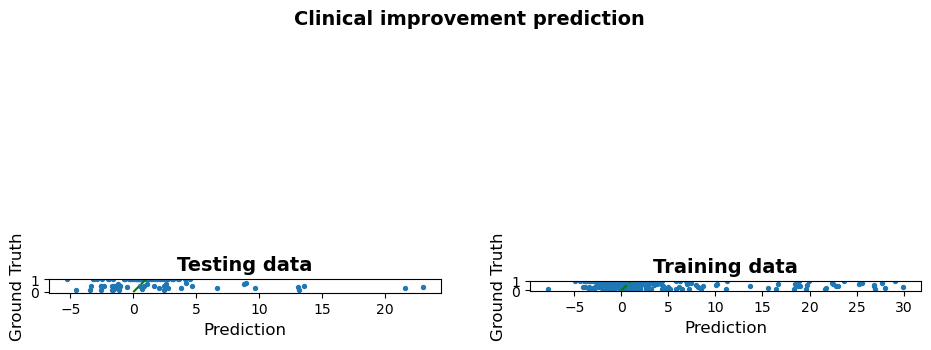

Coefficient of determination (R²):
     - testing  :     -237.45564836822493
     - training :     -408.1505382510987


In [110]:
from sklearn.svm import SVR
model = SVR(kernel='sigmoid')
#kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’,
model = model.fit(X_train, (y_train))
plot_results(model, X_test, (y_test), X_train, (y_train), transformed=False)

### RBF kernel

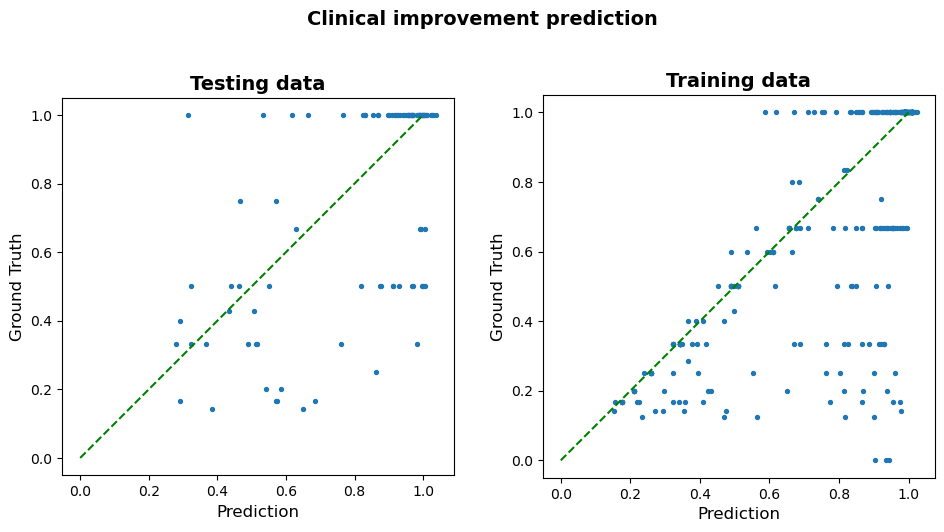

Coefficient of determination (R²):
     - testing  :     0.3129671027985881
     - training :     0.5579798959843183


In [111]:
from sklearn.svm import SVR
model = SVR(kernel='rbf', gamma='scale', tol=0.001, C=0.5, epsilon=0.01)
#kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’,
model = model.fit(X_train, (y_train))
plot_results(model, X_test, (y_test), X_train, (y_train), transformed=False)

## Ensembling
### Bagging elastic net

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/brainstimmaps/.conda/envs/PSM/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028380184042060996, tolerance: 0.003627139582028531
  positive)
/home/brainstimmaps/.conda/envs/PSM/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008590240639012592, tolerance: 0.0034308955935737646
  positive)
/home/brainstimmaps/.conda/envs/PSM/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012856008021686627, tolerance: 0.003759699793539798
  positive)
/home/brainstimmaps/.conda/envs/PSM/lib

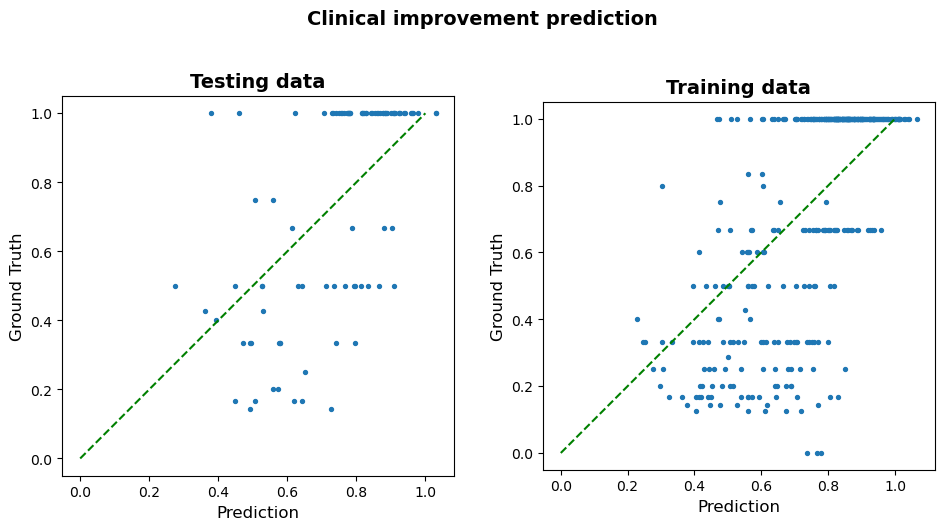

Coefficient of determination (R²):
     - testing  :     0.38055863514646326
     - training :     0.45462363772300673


AttributeError: 'BaggingRegressor' object has no attribute 'coef_'

In [112]:
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import ElasticNet

base_estimator =  ElasticNet(random_state=43, alpha=0.03, l1_ratio=0.05 , max_iter=10000)

model = BaggingRegressor(base_estimator=base_estimator, n_estimators=100, verbose=1, max_features=0.5, max_samples=0.2)
model = model.fit(X_train, y_train)
plot_results(model, X_test, y_test, X_train, y_train, transformed=False)

plot_map(model.coef_)

      Iter       Train Loss   Remaining Time 
         1           0.0970            0.95s
         2           0.0898            0.96s
         3           0.0834            0.94s
         4           0.0777            0.92s
         5           0.0732            0.91s
         6           0.0693            0.90s
         7           0.0660            0.89s
         8           0.0628            0.88s
         9           0.0599            0.87s
        10           0.0573            0.86s
        20           0.0407            0.78s
        30           0.0331            0.68s
        40           0.0279            0.58s
        50           0.0244            0.48s
        60           0.0212            0.38s
        70           0.0183            0.29s
        80           0.0159            0.19s
        90           0.0137            0.10s
       100           0.0121            0.00s


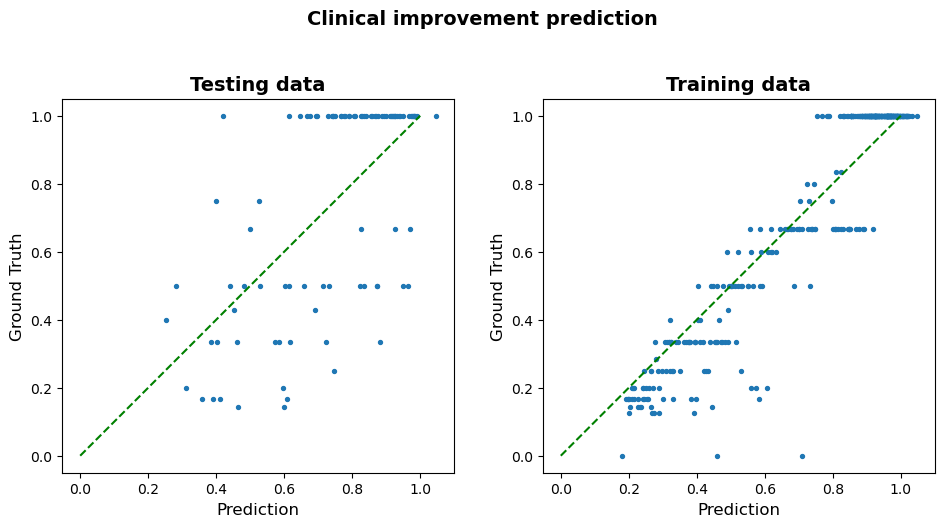

Coefficient of determination (R²):
     - testing  :     0.39769383481840026
     - training :     0.8851627465916909


In [62]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet

base_estimator = ElasticNet(random_state=43, alpha=0.01, l1_ratio=0.1 , max_iter=10000000)

model = GradientBoostingRegressor(n_estimators=100, verbose=1, max_features=0.5)
model = model.fit(X_train, y_train)
plot_results(model, X_test, y_test, X_train, y_train, transformed=False)



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import LinearSVC
from sklearn import set_config

steps = [
    ("preprocessing", StandardScaler()),
    ("classifier", LogisticRegression()),
]
pipe = Pipeline(steps)


clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
  ('classification', RandomForestClassifier())
])
clf.fit(X, y)

## Bagging tweedie regressor


## Pipeline
### Dimensionality reduction

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn import set_config

steps = [("reduce_dim", PCA(n_components=100)), ("regressor", BayesianRidge())]
model = Pipeline(steps)
set_config(display="diagram")
model.fit(X_train, y_train)
plot_results(model, X_test, y_test, X_train, y_train, transformed=False)

### Feature selection

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.feature_selection import SelectFromModel
from sklearn import set_config
from sklearn.linear_model import Lasso
from sklearn.svm import SVR

steps = [("feature selection", SelectFromModel(estimator=Lasso(alpha = 0.0001, max_iter=1e4))
), ("regressor", SVR(kernel="rbf"))]
model = Pipeline(steps)
set_config(display="diagram")
model.fit(X_train, np.squeeze(y_train.T))
plot_results(model, X_test, y_test, X_train, y_train)
plot_map(model, dim='2D')

In [ ]:
save_map(model)

In [ ]:
from scipy.optimize import minimize
from sklearn.linear_model import Lasso
from scipy.special import loggamma
from scipy.special import expit, logit
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

def logLikelihood(params, y, X):
    b = np.array(params[0:-1])      # the beta parameters of the regression model
    phi = params[-1]                # the phi parameter
    mu = expit(np.dot(X,b))

    eps = 1e-6                      # used for safety of the gamma and log functions avoiding inf
    res = - np.sum(loggamma(phi+eps) # the log likelihood
                   - loggamma(mu*phi+eps)
                   - loggamma((1-mu)*phi+eps)
                   + (mu*phi-1)*np.log(y+eps)
                   + ((1-mu)*phi-1)*np.log(1-y+eps))

    return res

def penalty(params, C=0, C1_ratio=0.5):
    return C * C1_ratio * np.linalg.norm(params, ord=1, axis=0) + C * (1 - C1_ratio) * np.linalg.norm(params, ord=2, axis=0)

def costFunction(params, y, X):
    return logLikelihood(params, y, X) + penalty(params)

# feature_selection = VarianceThreshold()
feature_selection = PCA(n_components=700)
feature_selection = feature_selection.fit(X_train)


X_train_selected_feat = feature_selection.transform(X_train)
X_test_selected_feat = feature_selection.transform(X_test)

x0 = np.ones(X_train_selected_feat.shape[1] + 1)
bounds = ((None, None),) * X_train_selected_feat.shape[1] + ((0, None),)
options = {"disp": True}

res = minimize(costFunction, x0=x0, args=(np.squeeze(y_train), X_train_selected_feat), bounds=bounds, options=options)

b = np.array(res.x[0:X_train_selected_feat.shape[1]])   # optimal regression parameters
pred_train = expit(np.dot(X_train_selected_feat, b))             # prediction
pred_test = expit(np.dot(X_test_selected_feat, b))             # predictions

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pred_test, y_test)
coef_deter_test = r_value**2

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pred_train, y_train)
coef_deter_train = r_value**2

# Create figure and axes
fig, axs = plt.subplots(1, 2)

# Set figure size and name
fig.tight_layout()
fig.suptitle('Clinical improvement prediction', y=0.8, fontsize=14, fontweight='bold')
fig.set_size_inches(25/2.54, 25/2.54)

# Set axe properties
axs[0].set_title('Testing data', fontdict=FONT_TITLE_PLOT)
axs[0].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
axs[0].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
axs[0].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
axs[0].scatter(pred_test, y_test, s=8)
axs[0].set_aspect('equal', 'box')
axs[0].set_xlim([-0.05, 1.05])
axs[0].set_ylim([-0.05, 1.05])

axs[1].set_title('Training data', fontdict=FONT_TITLE_PLOT)
axs[1].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
axs[1].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
axs[1].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
axs[1].scatter(pred_train, y_train, s=8)
axs[1].set_aspect('equal', 'box')
axs[1].set_xlim([-0.05, 1.05])
axs[1].set_ylim([-0.05, 1.05])

# Show figure
plt.show()

# Print the value of the R2
print("Coefficient of determination (R²):")
print("     - testing  :    ", coef_deter_test)
print("     - training :    ", coef_deter_train)

# Print the value of the R2
print("Number of features selected:   n = ", X_train_selected_feat.shape[1])

## PCA feature reduction

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

from sklearn.decomposition import PCA




steps = [("preproc", StandardScaler()), ("reduce_dim", PCA(n_components=200)), ("regressor", LinearRegression())]
model = Pipeline(steps)
set_config(display="diagram")
model.fit(X_train, y_train)
plot_results(model, X_test, y_test, X_train, y_train, transformed=False)

plot_map(model.named_steps['regressor'])

In [ ]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=200)
pls.fit(X_train, y_train)
plot_results(pls, X_test, y_test, X_train, y_train, transformed=False)

plot_map(pls)